# Smoker Status Prediction
**Author:** MT2025065

## Objective
To analyze the dataset, perform exploratory data analysis (EDA), and preprocess the data for machine learning modeling to predict smoker status.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


# Data Processing

## 1.1 Exploratory Data Analysis (EDA)

### 1.1.1 Initial Analysis

Dataset Dimensions

In [24]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (38984, 23)
Test dataset shape: (16708, 22)


Count of Numerical and Categorical Features

In [25]:
target_col = "smoking"
features = train_df.drop(columns=[target_col])

numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numerical Features (", len(numerical_features), "):", numerical_features)
print("Categorical Features (", len(categorical_features), "):", categorical_features)


Numerical Features ( 22 ): ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
Categorical Features ( 0 ): []


### 1.1.2 Target Distribution
We visualize the count of smokers vs. non-smokers to check for class imbalance. Calculating the ratio helps decide if we need specific handling techniques (like stratified splitting or resampling) to prevent the model from ignoring the minority class.

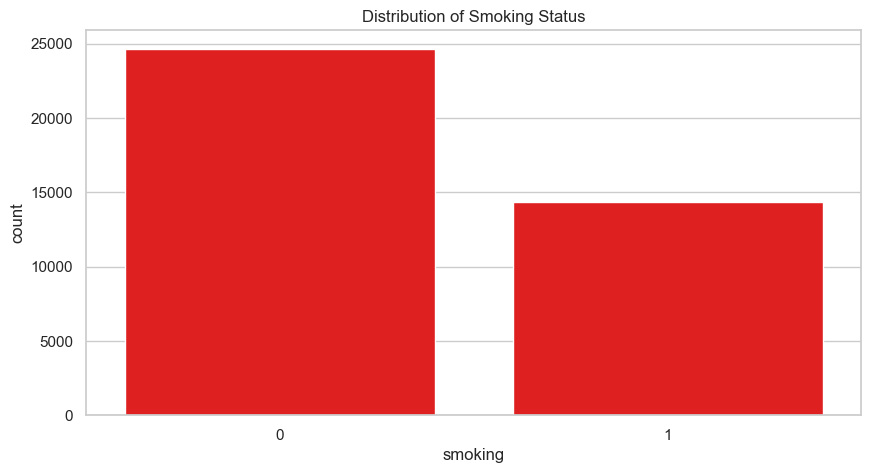

smoking
0    0.632721
1    0.367279
Name: proportion, dtype: float64

Class Counts:
 smoking
0    24666
1    14318
Name: count, dtype: int64

Class Proportions:
 smoking
0    0.632721
1    0.367279
Name: proportion, dtype: float64

Minority class to Majority class ratio: 0.580


In [26]:
plt.figure(figsize=(10, 5))
sns.countplot(x='smoking', data=train_df, color='red')
plt.title('Distribution of Smoking Status')
plt.show()

print(train_df['smoking'].value_counts(normalize=True))
counts = train_df['smoking'].value_counts()
proportions = train_df['smoking'].value_counts(normalize=True)

print("\nClass Counts:\n", counts)
print("\nClass Proportions:\n", proportions)

imbalance_ratio = counts.min() / counts.max()
print(f"\nMinority class to Majority class ratio: {imbalance_ratio:.3f}")


### 1.1.3 Numerical Features Distribution
Histograms are plotted for all numerical features to reveal their underlying distributions (e.g., Normal vs. Skewed). This helps identify features that may need normalization or log-transformation to improve model convergence.

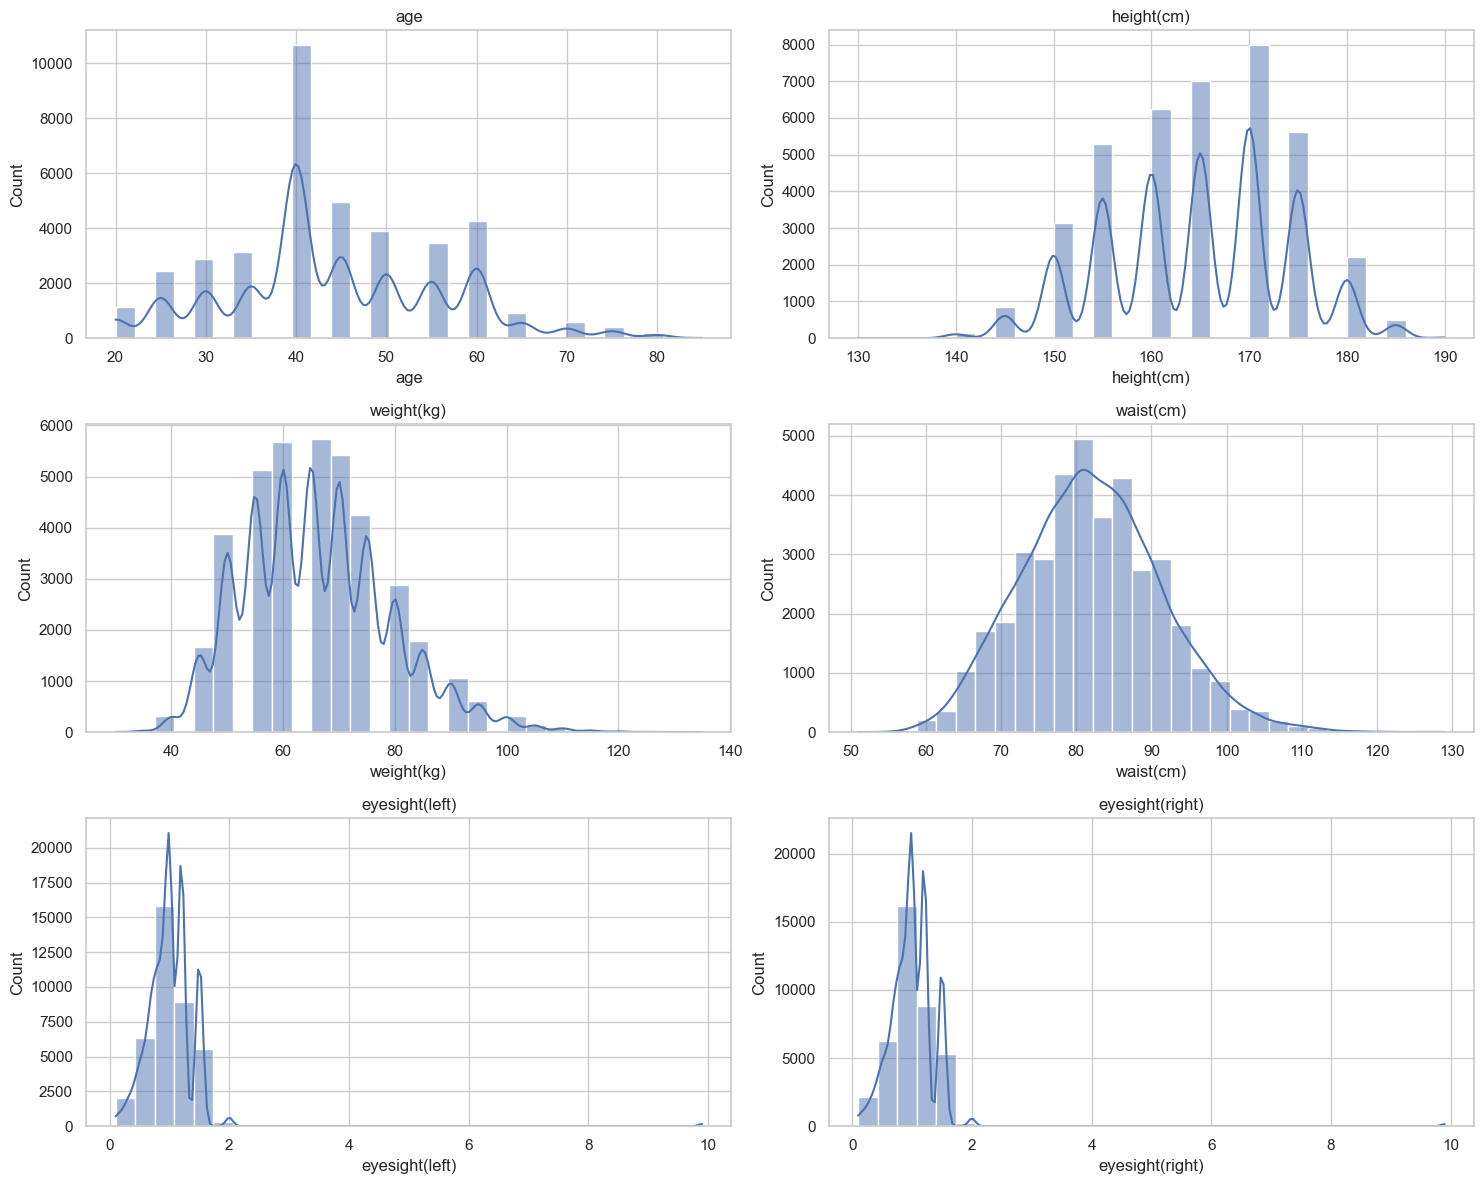

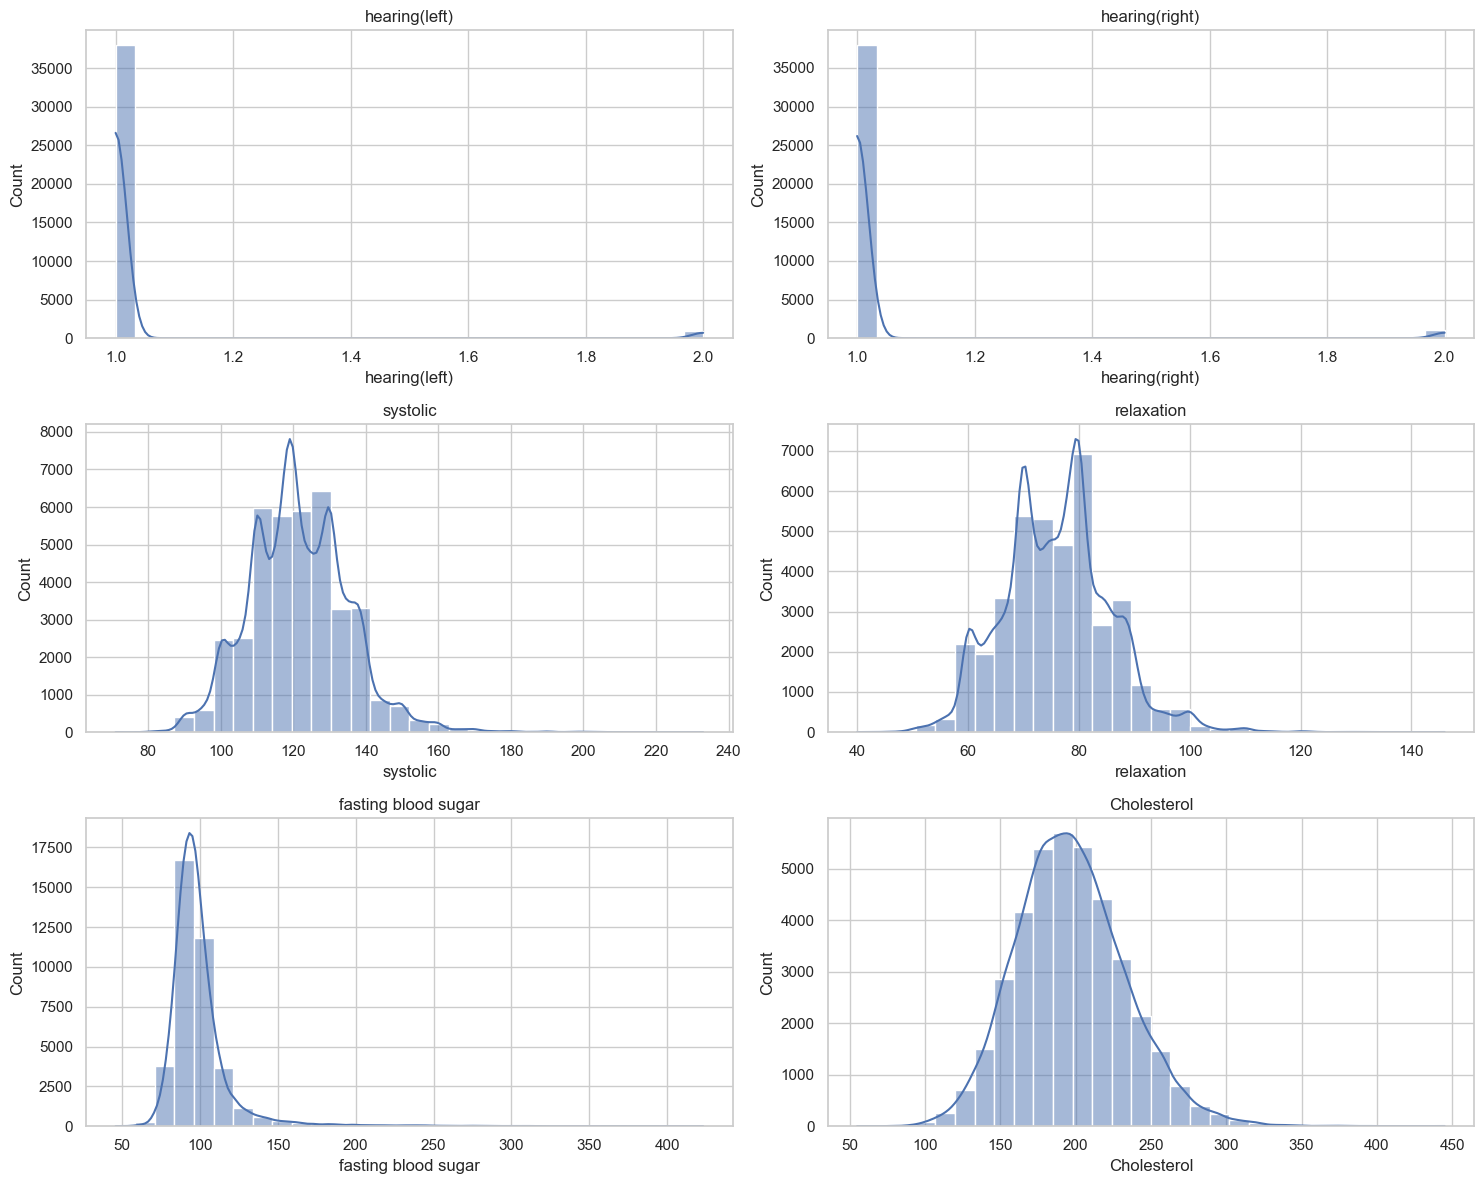

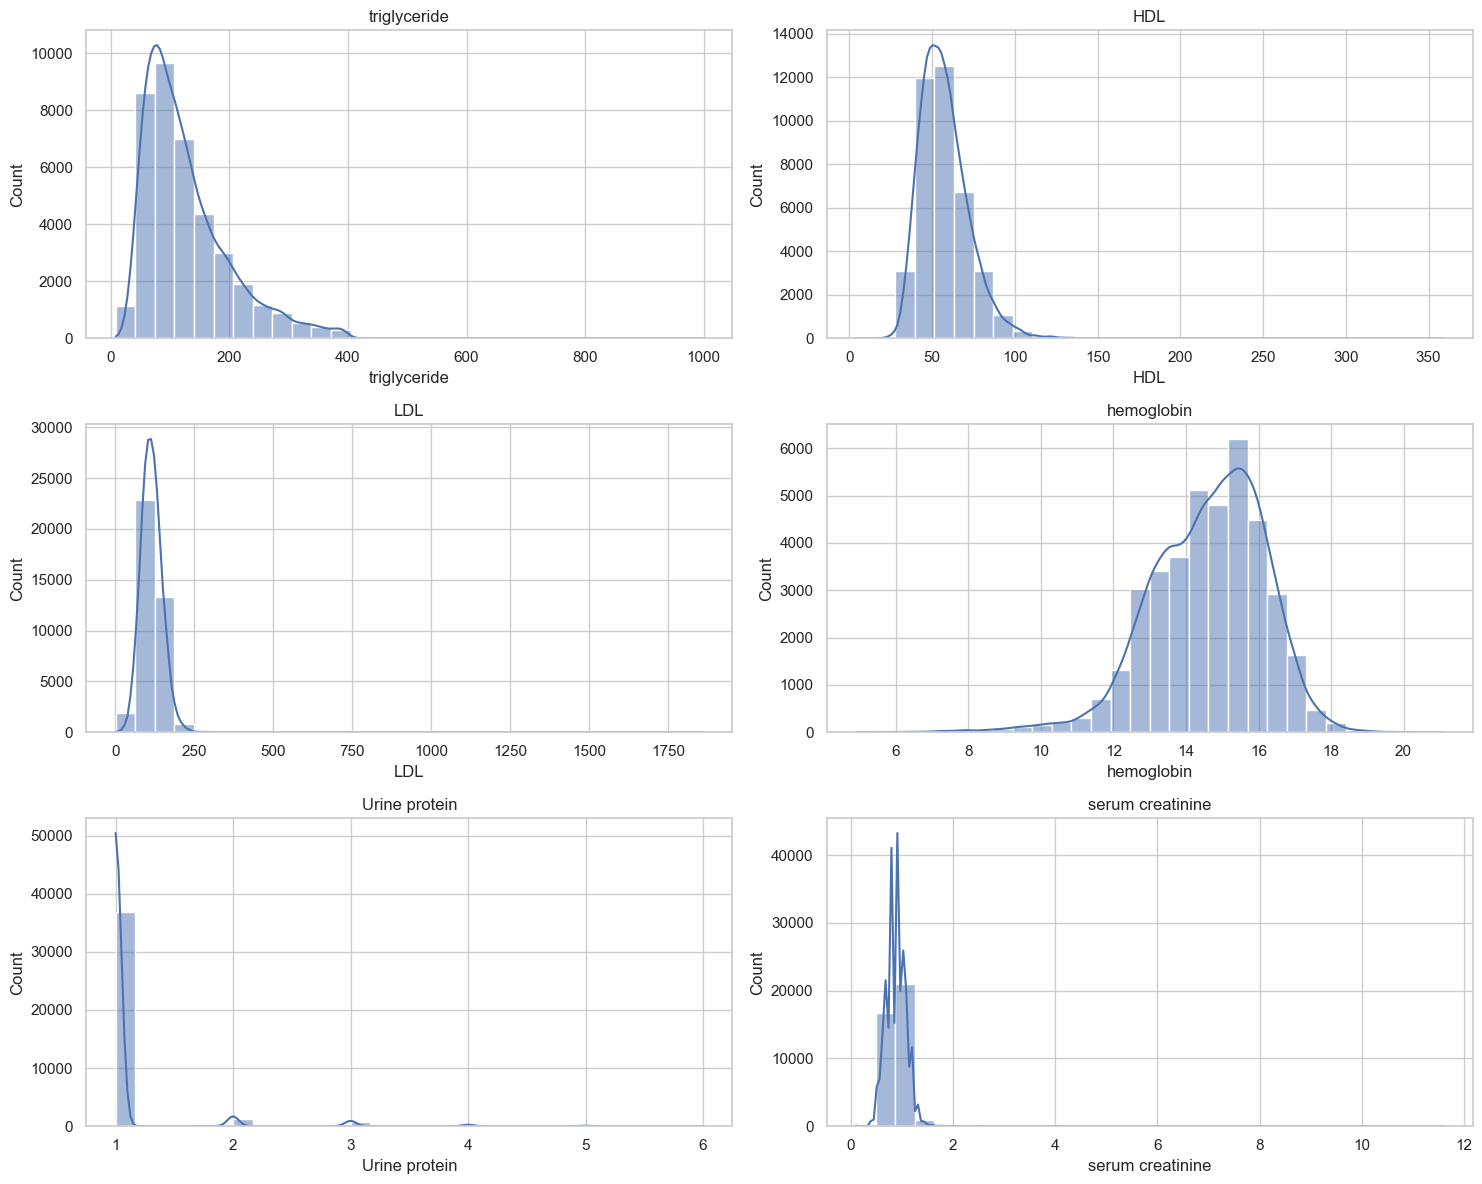

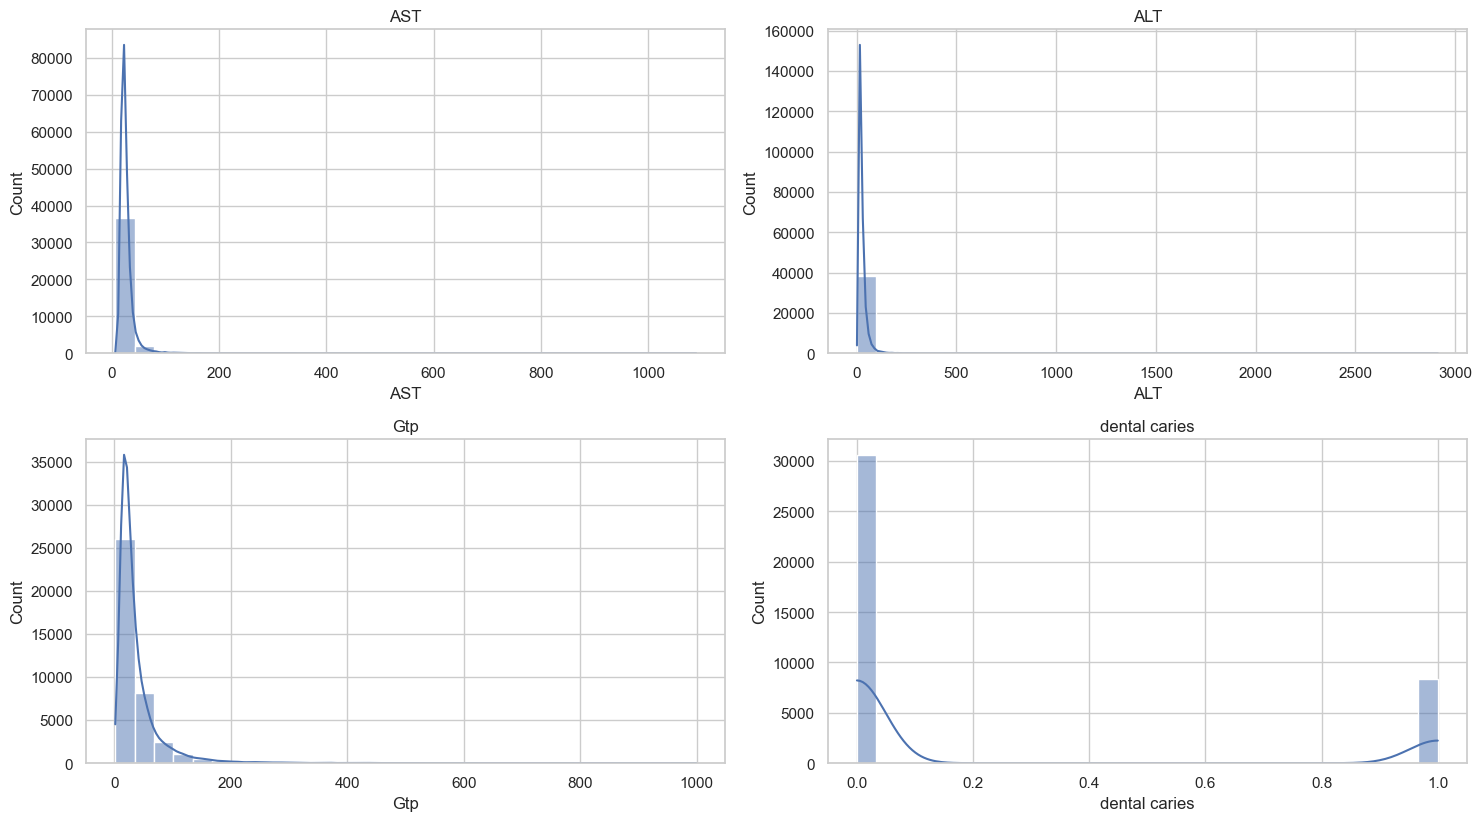

In [27]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove("smoking")

cols_per_fig = 6
total_cols = len(numerical_cols)
num_figs = math.ceil(total_cols / cols_per_fig)

for fig_idx in range(num_figs):
    start = fig_idx * cols_per_fig
    end = start + cols_per_fig
    cols_subset = numerical_cols[start:end]

    plt.figure(figsize=(15, 12))
    
    for i, col in enumerate(cols_subset, 1):
        plt.subplot(3, 2, i)
        sns.histplot(train_df[col], bins=30, kde=True)
        plt.title(col, fontsize=12)

    plt.tight_layout()
    plt.show()

### 1.1.4 Outlier Handling
We compare Z-score and Interquartile Range (IQR) methods on 'triglyceride' data to detect extreme outliers. This analysis guides whether we should remove these data points or apply transformations (like log) to reduce their impact without losing data.

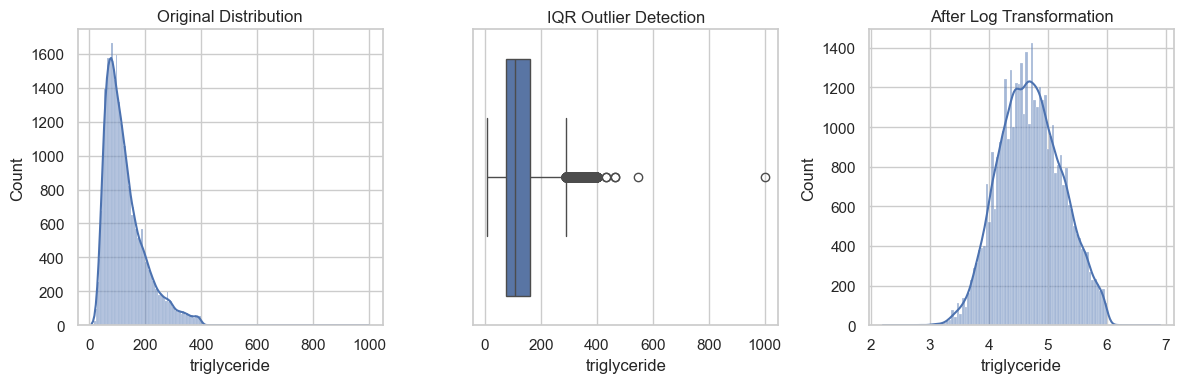

Z-score would remove 641 samples
IQR would remove 1607 samples


In [28]:
from scipy.stats import zscore

feature = 'triglyceride'
z_scores = zscore(train_df[feature])
z_outliers = train_df[np.abs(z_scores) > 3]

Q1 = train_df[feature].quantile(0.25)
Q3 = train_df[feature].quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = train_df[
    (train_df[feature] < Q1 - 1.5*IQR) | 
    (train_df[feature] > Q3 + 1.5*IQR)
]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(train_df[feature], kde=True)
plt.title("Original Distribution")

plt.subplot(1,3,2)
sns.boxplot(x=train_df[feature])
plt.title("IQR Outlier Detection")

plt.subplot(1,3,3)
sns.histplot(np.log1p(train_df[feature]), kde=True)
plt.title("After Log Transformation")

plt.tight_layout()
plt.show()

print(f"Z-score would remove {len(z_outliers)} samples")
print(f"IQR would remove {len(iqr_outliers)} samples")


### 1.1.5 Correlation Analysis
A heatmap is generated to quantify linear relationships between variables. This highlights features strongly correlated with the target ('smoking') for selection and detects multicollinearity between input features that might confuse the model.

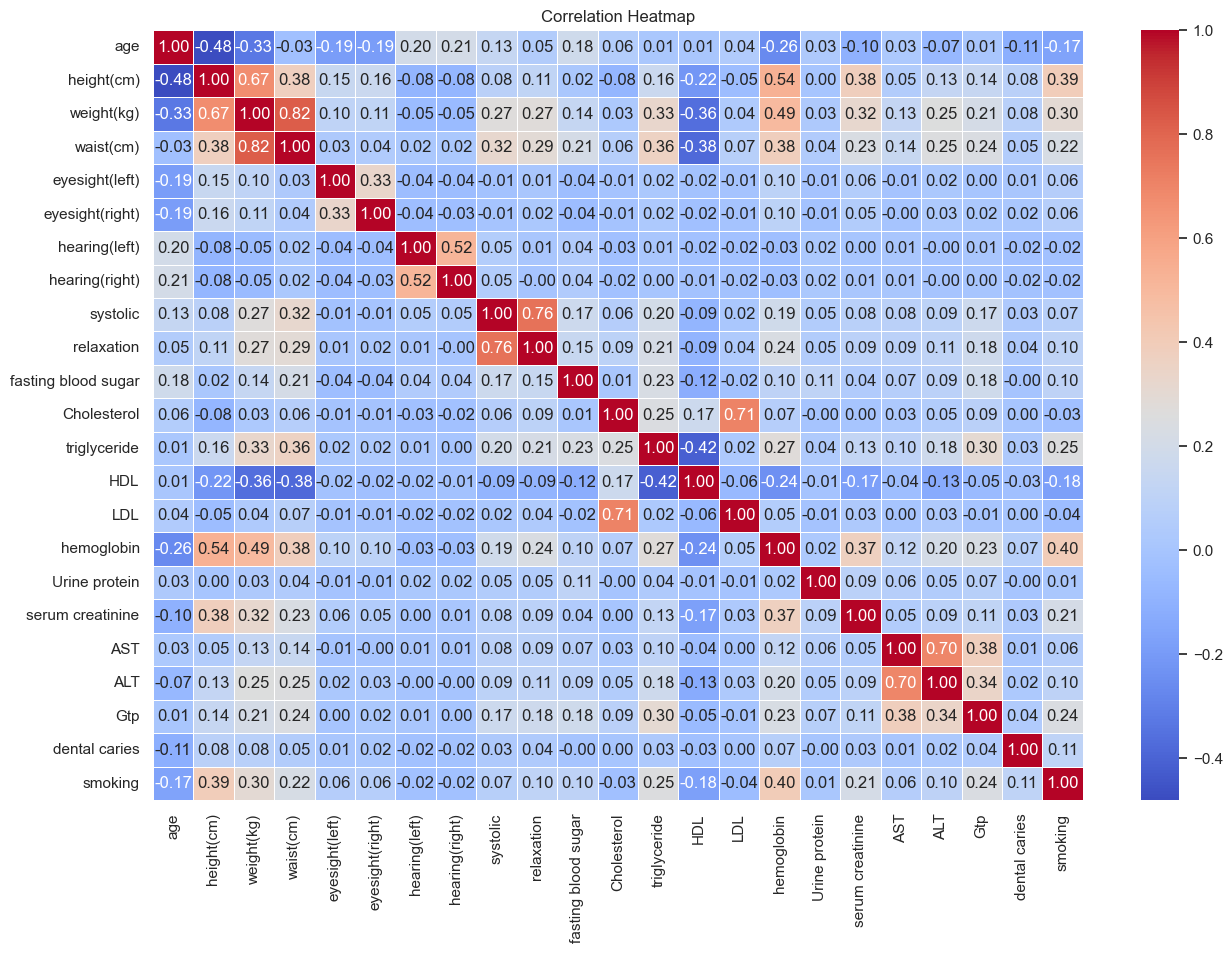

hemoglobin             0.401206
height(cm)             0.394314
weight(kg)             0.299347
triglyceride           0.251057
Gtp                    0.240274
waist(cm)              0.223359
serum creatinine       0.212473
dental caries          0.107601
relaxation             0.103663
fasting blood sugar    0.099908
ALT                    0.098615
systolic               0.070176
eyesight(right)        0.064587
AST                    0.062834
eyesight(left)         0.059409
Urine protein          0.013653
hearing(right)        -0.018990
hearing(left)         -0.022077
Cholesterol           -0.027493
LDL                   -0.041627
age                   -0.166268
HDL                   -0.179509
Name: smoking, dtype: float64

In [29]:
plt.figure(figsize=(15, 10))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
target_corr = train_df.corr()['smoking'].drop('smoking').sort_values(ascending=False)
display(target_corr)

### 1.1.6 Target Value Analysis
Boxplots allow us to visually compare the central tendency and spread of key bio-signals. This confirms if features like 'hemoglobin' or 'Gtp' show distinct separation between smokers and non-smokers, validating their predictive power.

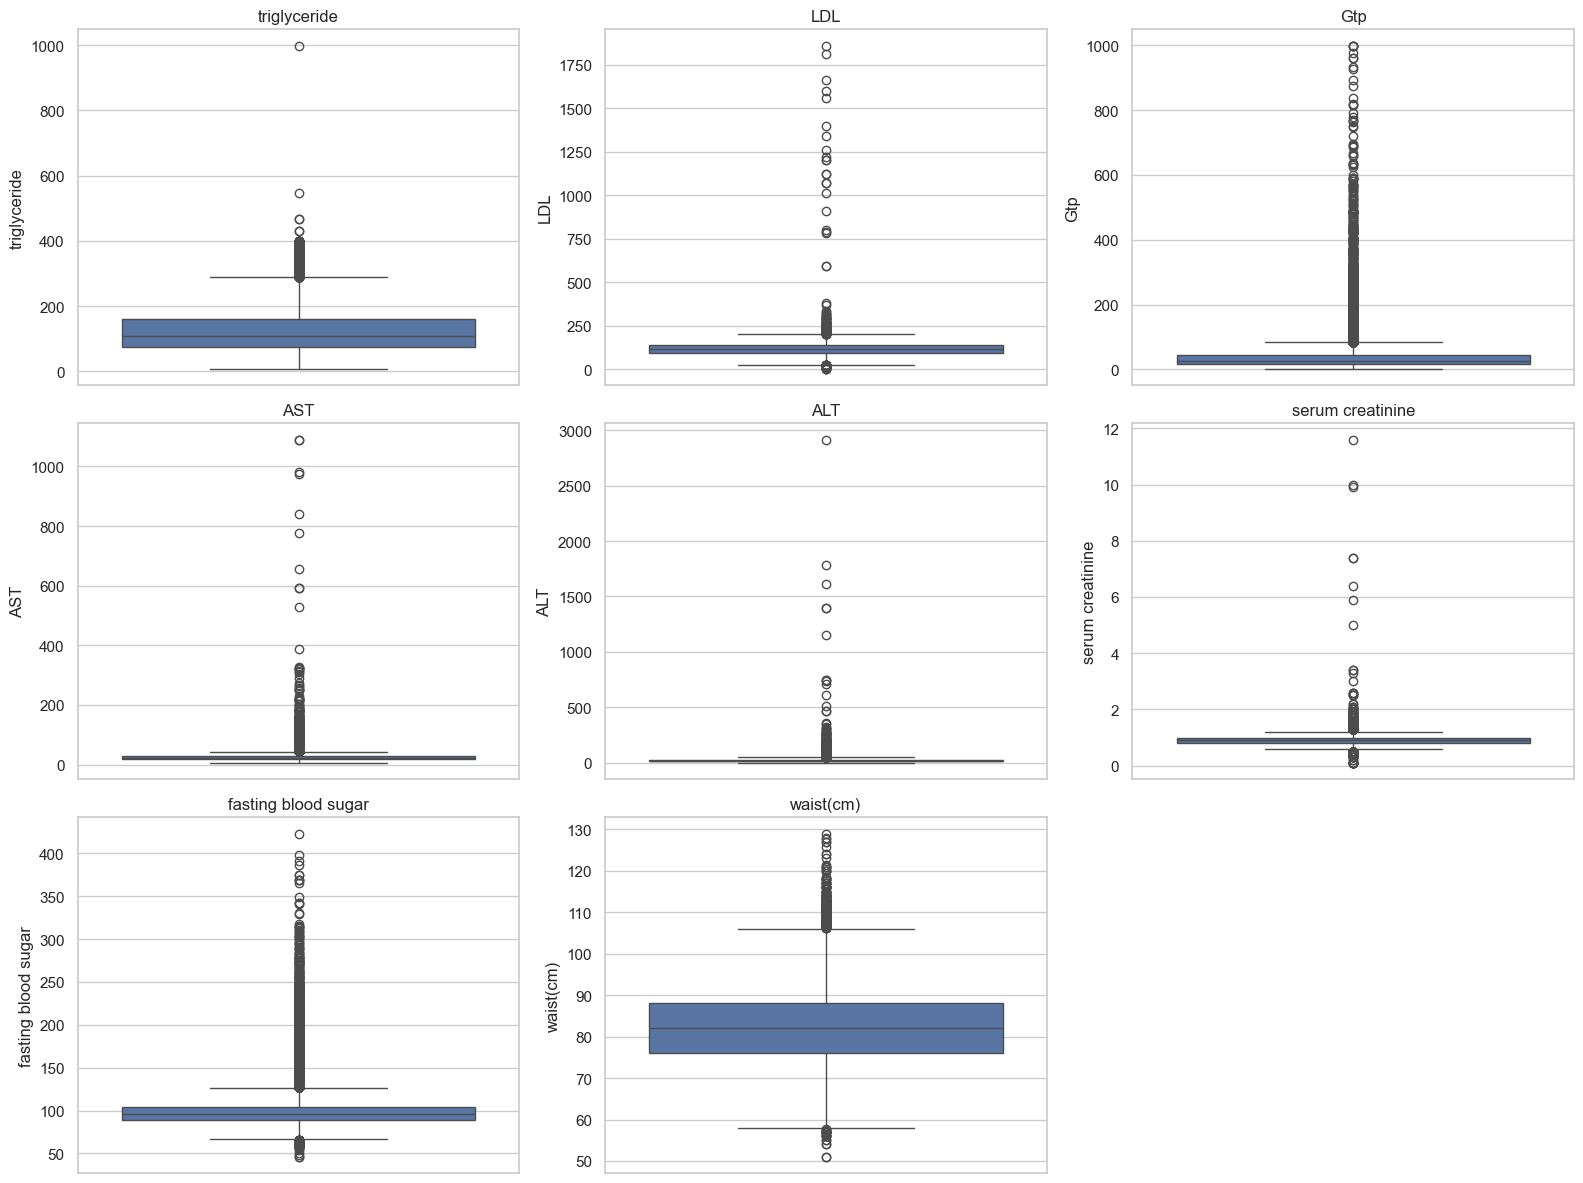

In [30]:
key_features = ['triglyceride', 'LDL', 'Gtp', 'AST', 'ALT', 
                'serum creatinine', 'fasting blood sugar', 'waist(cm)']

plt.figure(figsize=(16, 12))
for i, col in enumerate(key_features, 1):
    if col in train_df.columns:
        plt.subplot(3, 3, i)
        sns.boxplot(y=train_df[col])
        plt.title(col)

plt.tight_layout()
plt.show()

## 1.2 Data Preprocessing

### 1.2.1 Data Loading and Exploration
We examine the data types and check for null values to assess data quality. Duplicate rows are identified and removed to prevent the model from memorizing identical samples, ensuring unbiased training.

In [31]:
display(train_df.head())

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [32]:
#checking the info of train and test data
print("--- Train Info ---")
train_df.info()
print("\n--- Test Info ---")
test_df.info()

--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin       

In [33]:
#checking missing values
print("Missing values in Train:")
print(train_df.isnull().sum())
print("\nMissing values in Test:")
print(test_df.isnull().sum())

Missing values in Train:
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Missing values in Test:
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL         

In [34]:
#checking and removing the duplicates
duplicates = train_df.duplicated().sum()
print(f"Duplicate rows in Train: {duplicates}")

if duplicates > 0:
    train_df = train_df.drop_duplicates()
    print("Duplicates removed.")

Duplicate rows in Train: 5517
Duplicates removed.


### 1.2.2 Handle Categorical Features
We identify object-type columns to determine if encoding (like One-Hot) is needed. Since bio-signal datasets are primarily numeric, this step confirms we are ready for scaling without complex text processing.

In [35]:
object_cols = train_df.select_dtypes(include=['object']).columns
print(f"Object columns: {object_cols}")

Object columns: Index([], dtype='object')


### 1.2.3 Handle Numerical Features
We define the features (X) and target (y) and initialize RobustScaler. RobustScaler is chosen because it uses the median and IQR, making it resilient to the outliers we observed in the 'triglyceride' EDA.
The scaler is fit only on the training data and then applied to the validation/test sets. This prevents "data leakage" (information from the test set influencing the model) and ensures valid performance metrics.

In [39]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_df)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

display(X_train_scaled.head())


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,1.000000,-0.5,-0.25,-0.141667,0.00,0.50,0.0,0.0,-0.555556,0.333333,...,0.235294,-0.111111,1.386364,-0.545455,0.0,-0.5,-0.2,-0.1250,-0.185185,1.0
1,0.666667,-1.0,-1.00,-1.316667,-1.75,-1.25,0.0,0.0,1.666667,2.000000,...,0.105882,-0.277778,-0.227273,-0.090909,0.0,-1.0,0.3,-0.1875,-0.185185,0.0
2,0.333333,-0.5,0.25,-0.333333,-0.50,-0.25,0.0,0.0,-0.111111,-0.500000,...,-0.388235,-0.500000,-0.022727,-0.909091,0.0,-1.5,1.8,3.5000,-0.037037,0.0
3,0.000000,0.0,-0.25,-0.333333,-0.75,-0.50,0.0,0.0,-1.166667,-1.250000,...,-0.905882,1.611111,0.227273,-1.045455,0.0,-0.5,-0.5,-0.7500,-0.370370,1.0
4,0.666667,0.5,-0.50,-0.833333,0.00,0.50,0.0,0.0,1.000000,0.166667,...,0.023529,-0.222222,-0.318182,0.272727,0.0,0.5,0.0,-0.4375,-0.333333,0.0


### 1.2.4 Train-Validation Split
We split the data into training and validation sets using stratify=y. This ensures the proportion of smokers remains consistent in both sets, providing a fair evaluation metric for the model.

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (26773, 22)
X_val shape: (6694, 22)
